Links:
- https://github.com/hardmaru/WorldModelsExperiments
- http://blog.otoro.net//2018/06/09/world-models-experiments/


In [1]:
%matplotlib inline
# notebook stuff
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

# numpy
import numpy as np
from PIL import Image

# torch stuff
import torch
import torch.nn as nn
from torchvision.transforms import Compose, ToTensor, ToPILImage
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
from torchsummary import summary

# our stuff
import constants

import importlib
import vaelin
VAELin = importlib.reload(vaelin).VAELin
import vae
VAE = importlib.reload(vae).VAE
from dataset import VAEDataset

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0

In [3]:
all_data = VAEDataset(size=100000, transform=ToTensor())

In [27]:
def get_full_dataset(dataset):
    return torch.stack([dataset[i] for i in range(len(dataset))])

In [58]:
full_data = get_full_dataset(all_data)

In [99]:
def get_sample_weights(data):
    # preprocess dataset to inverted grayscale

    norm_dataset = (1-(data.sum(1)/3)).numpy()
    # get peaks of pixel distributions
    norm_px_dist = norm_dataset.sum(1)
    peaks = np.argmax(norm_px_dist, axis=1)
    #counts of peaks at x coordinates
    counts = np.bincount(peaks)

    # we invert the counts, normalize, and take softmax so low counts have high prob and high counts have low prob
    # norm_inv_counts = (-counts + counts.mean())/(counts.max() - counts.mean())
    # samp_prob = np.exp(norm_inv_counts)/np.exp(norm_inv_counts).sum())

    # replace each sample's peak with the count class of that peak
    counts_by_peaks = counts[peaks]
    # same as above except instead of a sample prob across counts
    # it's a sample prob across samples weighted by its count class
    norm_inv_counts_by_peaks = (-counts_by_peaks + counts_by_peaks.mean())/(counts_by_peaks.max() - counts_by_peaks.mean())
    samp_prob_by_peaks = np.exp(norm_inv_counts_by_peaks)/np.exp(norm_inv_counts_by_peaks).sum()

    return samp_prob_by_peaks


In [100]:
def get_peaks(data):
    norm_dataset = (1-(data.sum(1)/3)).numpy()
    # get peaks of pixel distributions
    norm_px_dist = norm_dataset.sum(1)
    peaks = np.argmax(norm_px_dist, axis=1)
    return peaks

In [101]:
sample_weights = get_sample_weights(full_data)

In [90]:
peaks = get_peaks(full_data)

In [80]:
resampled = np.random.choice(a=, size=100000, p=sample_weights)

In [93]:
count_after = np.bincount(resampled)
count_before = np.bincount(get_peaks(full_data))

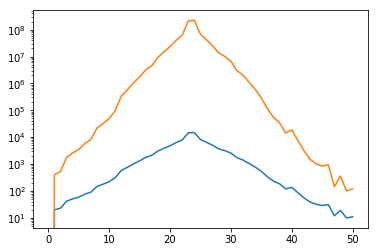

In [98]:
plt.semilogy(np.bincount(peaks))
plt.semilogy(np.bincount(peaks)**2)

In [75]:
(count_after - count_before)

array([     0,     33,     21,     43,     70,     80,     98,    109,
          155,    219,    317,    407,    608,    814,    970,   1277,
         1467,   1578,   1718,   1295,   1019,   -200,  -1786,  -9832,
       -10552,  -1976,   -480,    780,   1392,   1537,   1754,   1519,
         1284,   1063,    802,    621,    441,    342,    206,    145,
          194,    132,     69,     68,     42,     43,     40,     16,
           15,     11,     12])

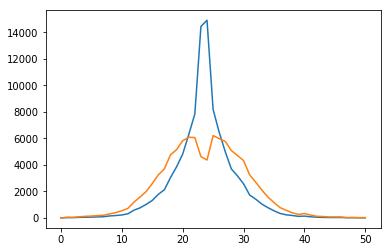

In [76]:
plt.plot(count_before)
plt.plot(count_after)
plt.show()

In [82]:
(count_after - count_before)

array([     0,      3,      3,     41,     26,     35,     30,     53,
           82,    121,    119,    163,    325,    376,    510,    690,
          958,    983,   1419,   1559,   1544,   1086,    -16,  -9509,
       -10232,   -432,   1138,   1426,   1490,   1320,   1201,    874,
          699,    490,    380,    291,    219,    122,     80,     69,
           94,     32,     34,     17,     26,     13,     21,     11,
           12,      4,      0])

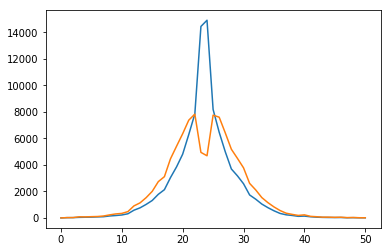

In [83]:
plt.plot(count_before)
plt.plot(count_after)
plt.show()

In [102]:
sampler = WeightedRandomSampler(sample_weights, num_samples=10000, replacement=True)

In [103]:
batch_size=32
train_loader = DataLoader(all_data, batch_size=batch_size, sampler=sampler, num_workers=2)

In [104]:
# model = VAE(conv_sizes=[4,8,16,32], device=device).to(device)
model = VAELin(z_size=32, device=device).to(device)

summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Reshape-1                [-1, 12288]               0
            Linear-2                  [-1, 800]       9,831,200
              ReLU-3                  [-1, 800]               0
            Linear-4                   [-1, 32]          25,632
            Linear-5                   [-1, 32]          25,632
            Linear-6                  [-1, 800]          26,400
              ReLU-7                  [-1, 800]               0
            Linear-8                [-1, 12288]       9,842,688
           Reshape-9            [-1, 3, 64, 64]               0
          Sigmoid-10            [-1, 3, 64, 64]               0
Total params: 19,751,552
Trainable params: 19,751,552
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.40
Params size (MB): 75.35
Esti

In [105]:
losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [106]:
num_epochs = 20

In [108]:

for epoch in range(num_epochs):
    with tqdm_notebook(total=len(train_loader)) as bar:
        for batch_idx, train_batch in enumerate(train_loader):
            train_batch = train_batch.to(device)
            optimizer.zero_grad()
            original, decoded, encoded, z, mu, logvar = model.forward(train_batch)
            
            loss, _, _ = model.loss(original, decoded, mu, logvar)
            losses.append(loss.detach().cpu().numpy())
            loss.backward()
            optimizer.step()
            bar.update(1)
            bar.set_postfix(avg_loss=sum(losses[-(batch_idx+1):])/(batch_idx+1))

In [109]:
np_losses = np.array(losses)

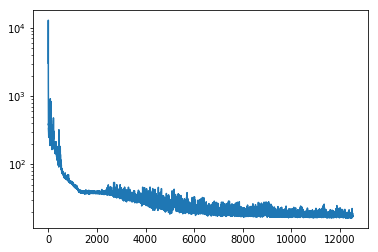

In [110]:
plt.semilogy(np_losses)

In [111]:
model.loss(original, decoded, mu, logvar)

(tensor(17.2681, device='cuda:0', grad_fn=<ThAddBackward>),
 tensor(16.0379, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward1>))

NameError: name 'dataset' is not defined

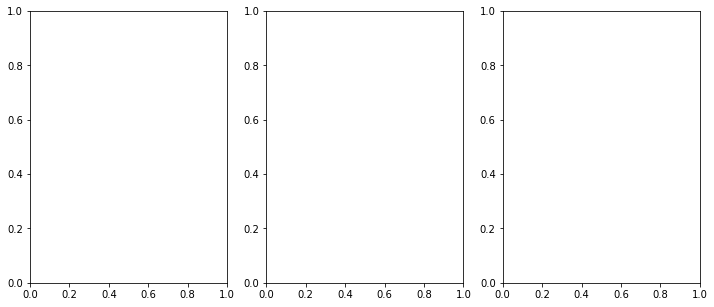

In [112]:
fig = plt.figure(figsize=(12,5))
ims = []
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)
for i in range(1000):
    temp = dataset[i].cuda(device).reshape((1, 3, 64, 64))
    inim = temp[0].detach().cpu().numpy().transpose((1,2,0))
    outim = model.forward(temp)[1][0].detach().cpu().numpy().transpose((1,2,0))
    im1 = ax1.imshow(np.abs(inim), animated=True)
    im2 = ax2.imshow(np.abs(outim-inim), animated=True)
    im3 = ax3.imshow(np.abs(outim), animated=True)
    ims.append([im1, im2, im3])
anim = animation.ArtistAnimation(fig, ims, interval=20, blit=True)

In [ ]:
vid = anim.to_html5_video()

In [114]:
HTML(vid)

In [17]:
len(dataset)

10000

0


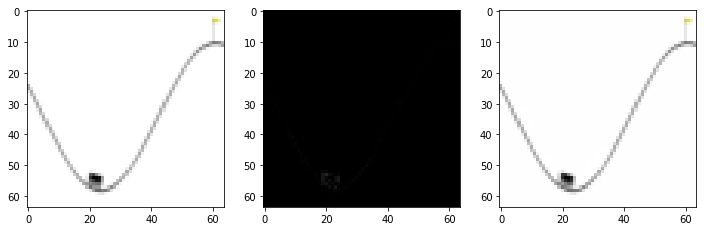

1


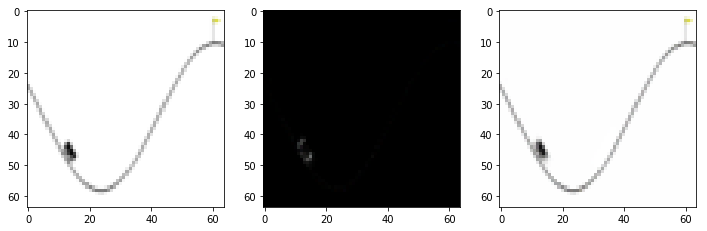

2


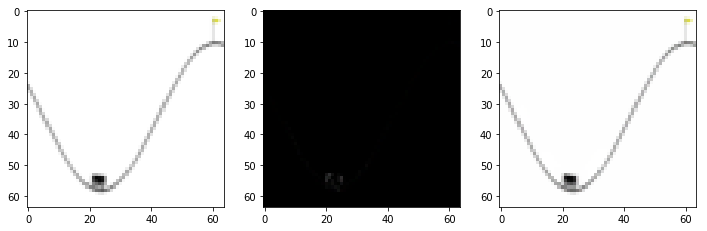

3


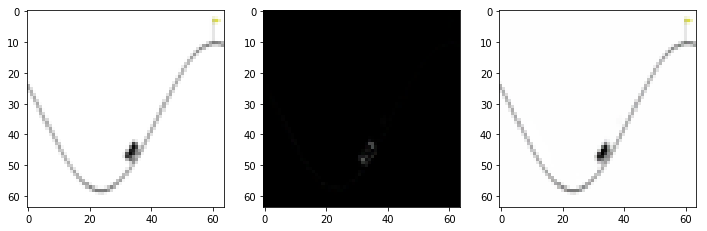

4


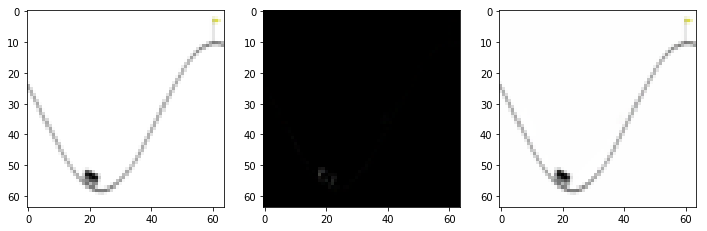

5


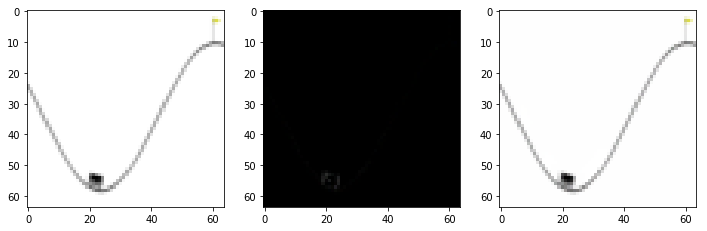

6


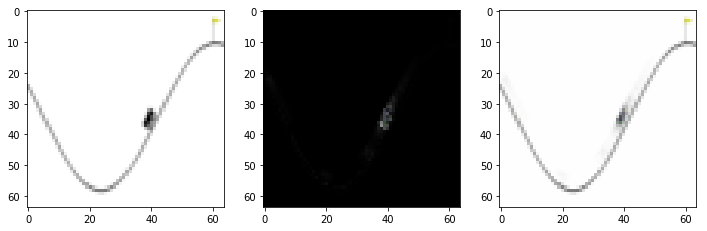

7


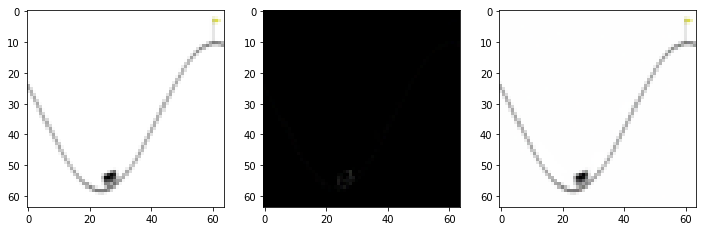

8


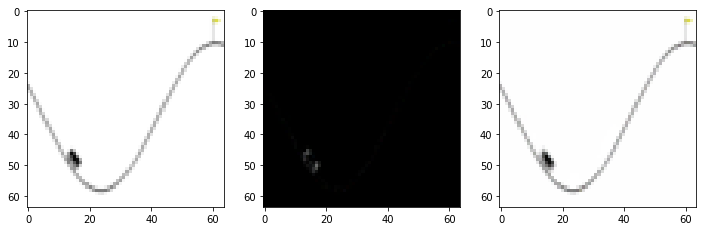

9


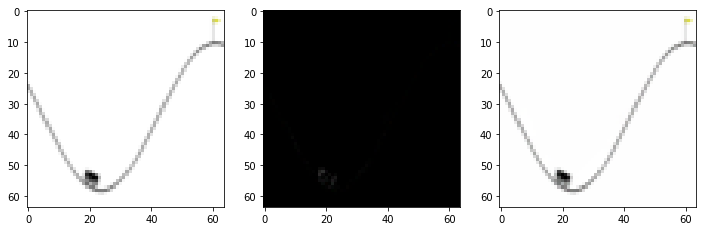

10


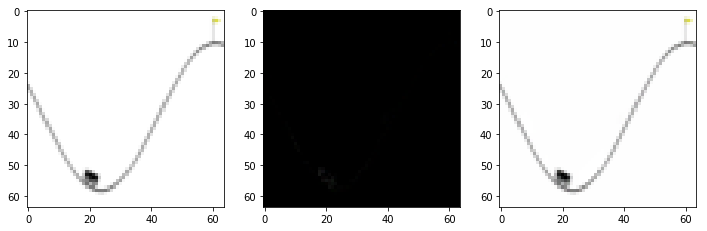

11


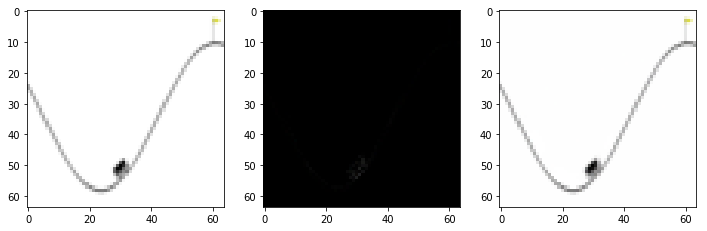

12


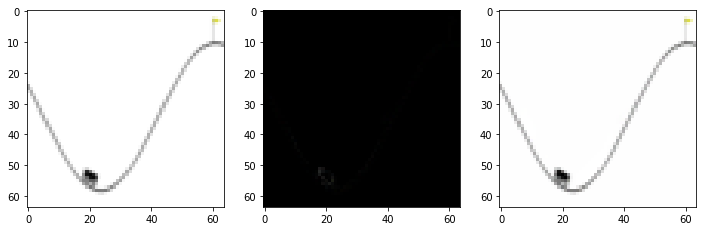

13


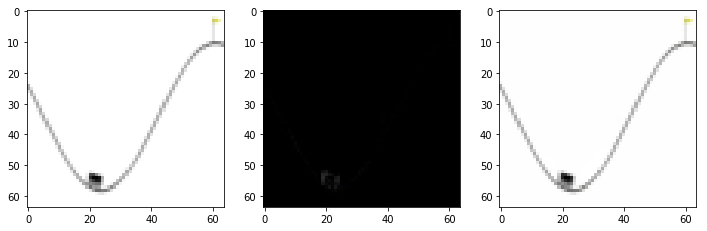

14


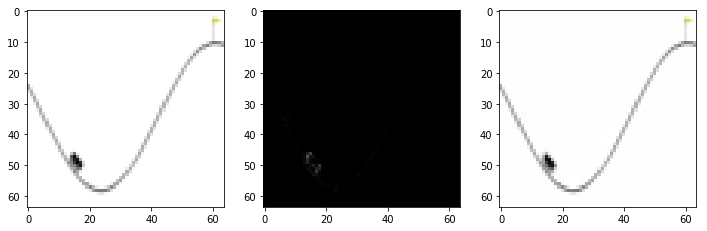

15


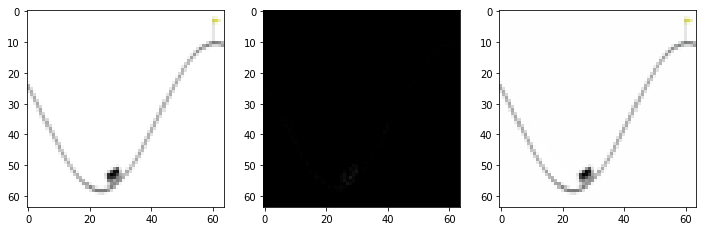

16


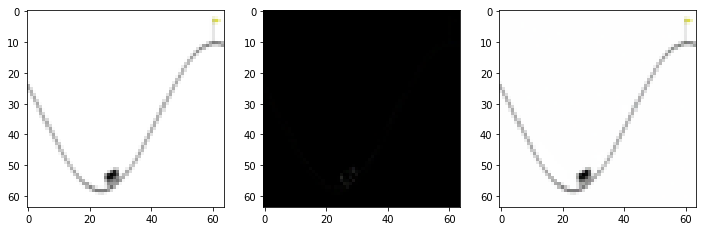

17


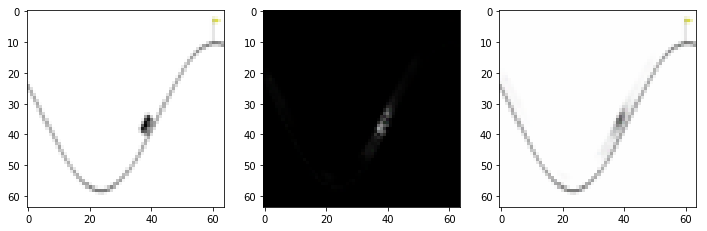

18


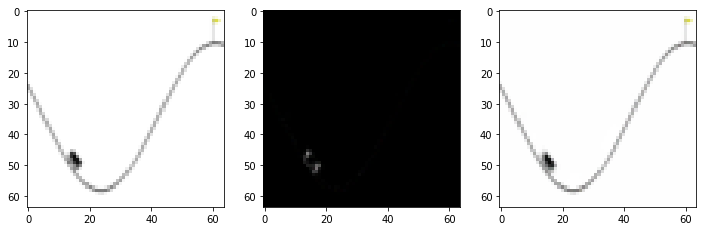

19


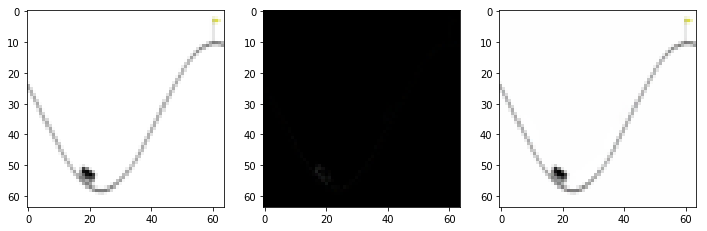

20


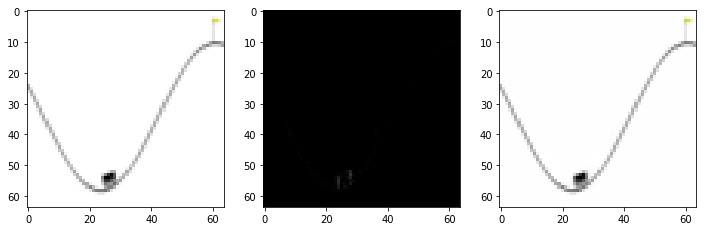

21


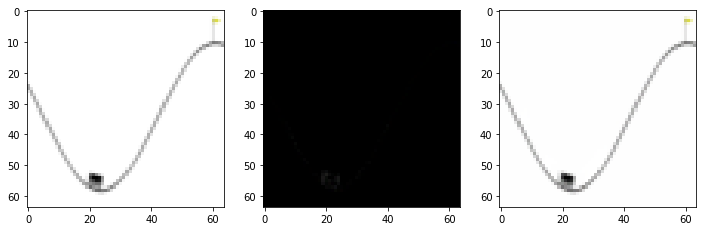

22


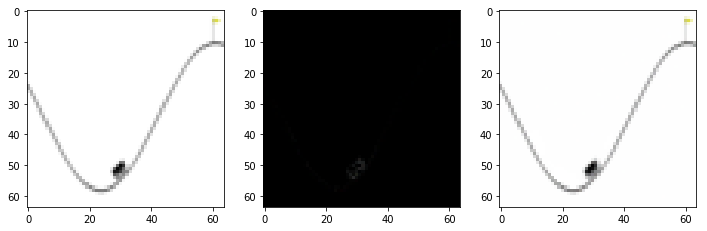

23


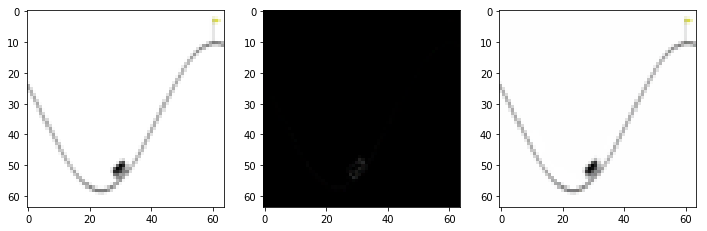

24


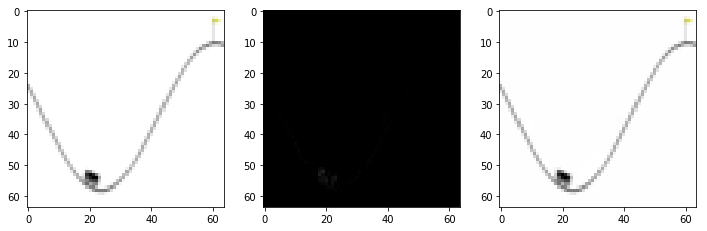

25


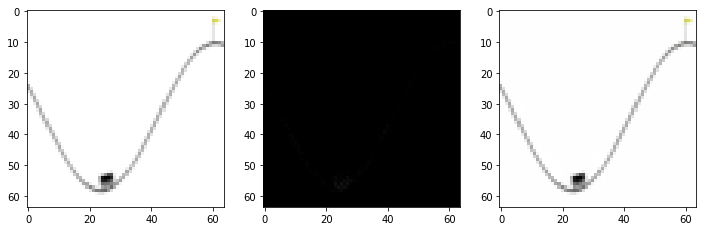

26


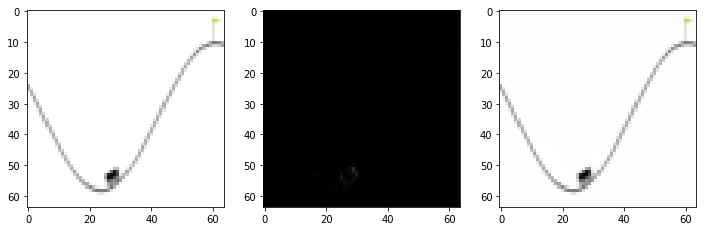

27


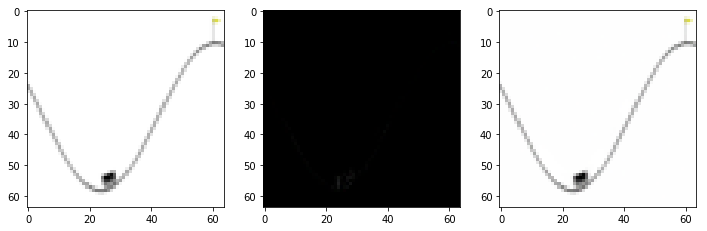

28


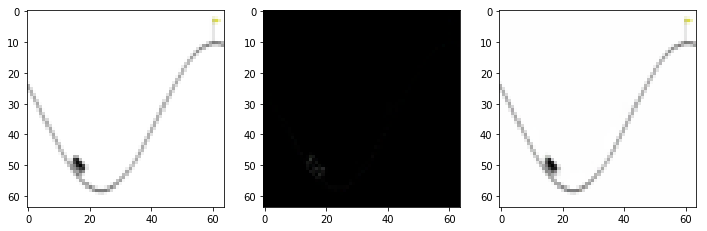

29


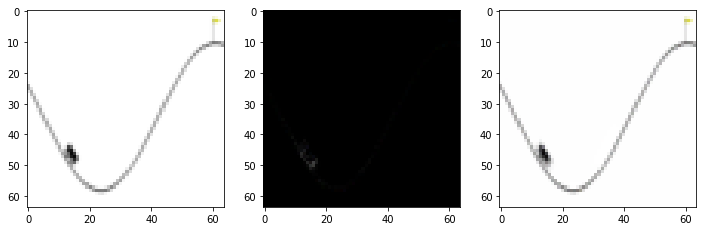

30


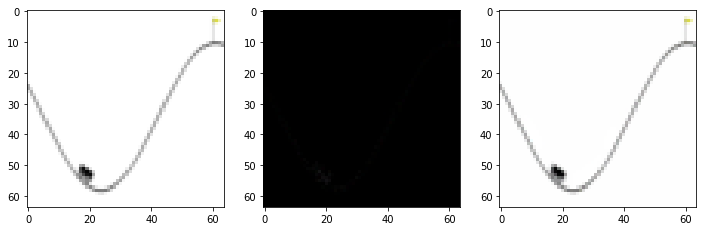

31


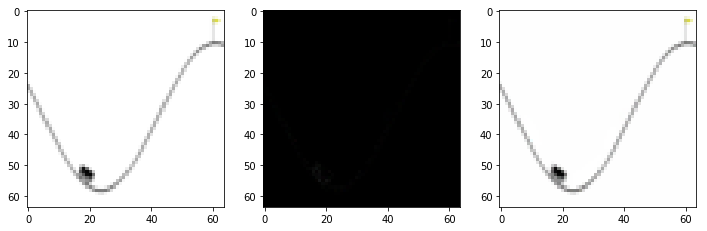

In [113]:

for batch_idx, train_batch in enumerate(train_loader):
    if batch_idx < 2:
        continue
    if batch_idx > 2:
        break
    for i in range(batch_size):
        temp = train_batch[i].cuda(device).reshape((1, 3, 64, 64))
        inim = temp[0].detach().cpu().numpy().transpose((1,2,0))
        outim = model.forward(temp)[1][0].detach().cpu().numpy().transpose((1,2,0))
        print(i)
        plt.figure(figsize=(12,5))
        plt.subplot(1,3,1)
        plt.imshow(np.abs(inim))
        plt.subplot(1,3,2)
        plt.imshow(np.abs(outim-inim))
        plt.subplot(1,3,3)
        plt.imshow(np.abs(outim))
        plt.show()


In [203]:
huge_data = np.array(VAEDataset(size=100000))

In [205]:
huge_data.shape

(100000, 64, 64, 3)

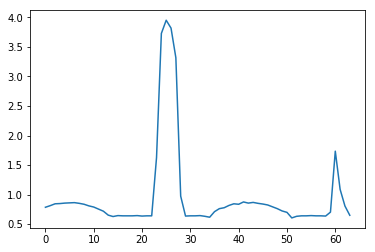

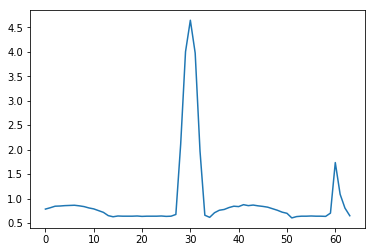

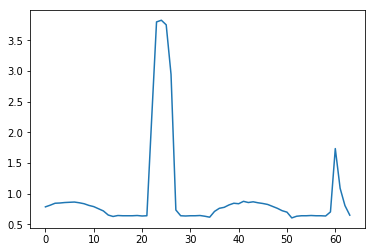

In [76]:
for i in [500, 700, 1500]:
    full_dataset[i].
    px_dist = (1-data).sum(0)
    plt.plot(px_dist)
    plt.show()